<a href="https://colab.research.google.com/github/sashafromlibertalia/deep-learning-labs/blob/main/seq2seq_Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Seq2seq для машинного перевода

В этом блокноте рассматриваются некоторые подходы к задаче машинного перевода с помощью

* Рекуррентных сетей
* Рекуррентных сетей с механизмом внимания
* Трасформеров

Первый и последний подходы уже реализованы. Вам предлагается реализовать второй подход, а именно интегрировать механизм внимания в рекуррентную НС. Для лучшего понимания рекомендуем ознакомиться [со следующей статьей](https://arxiv.org/pdf/1409.0473). Какой конкретно тип механизма внимания реализовывать остается на выбор студенту.

Для оценок трех рассмотренных подходов реализовать метрику BLEU. В качестве тестовой выборки можно использовать валидационный набор. Или произвести требуемое разделение самостоятельно.

В качестве резюме (на 3 балла):

1. Разобраться в задаче и в коде
2. Добавить внимание к рекуррентной сети
3. Реализовать BLEU
4. Сравнить полученные 3 модели между собой.
5. **Опционально (+1 балл)**: продемонстрировать alignment между словами на исходном и целевом языках (аналогично Figure 3 в предложенной статье).
6. **Опционально (+1 балл)**: сравнить 3 полученных модели (по метрике) между собой на парах различной длины. Например, вычислить метрики на коротких, средних и длинных предложениях. Если средних/длинных предложений нет в выборке -- сгенерировать самостоятельно, например через LLM.

# Загрузка данных

In [1]:
!wget http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
!unzip -q spa-eng.zip

--2025-06-10 22:54:00--  http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.207, 142.250.101.207, 142.250.141.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2638744 (2.5M) [application/zip]
Saving to: ‘spa-eng.zip.1’

spa-eng.zip.1       100%[===================>]   2.52M  --.-KB/s    in 0.01s   

2025-06-10 22:54:00 (254 MB/s) - ‘spa-eng.zip.1’ saved [2638744/2638744]

replace spa-eng/_about.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace spa-eng/spa.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


In [2]:
text_file = "spa-eng/spa.txt"
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    english, spanish = line.split("\t")
    spanish = "[start] " + spanish + " [end]"
    text_pairs.append((english, spanish))

In [3]:
import random
import numpy as np
print(random.choice(text_pairs))

('We got behind the car and pushed.', '[start] Nos situamos detrás del coche y empujamos. [end]')


In [4]:
import random
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples:num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples:]

**Векторизация пар**

In [5]:
%%time
import tensorflow as tf
import string
import re
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model

strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")

vocab_size = 15000
sequence_length = 20

source_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
target_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_english_texts = [pair[0] for pair in train_pairs]
train_spanish_texts = [pair[1] for pair in train_pairs]
source_vectorization.adapt(train_english_texts)
target_vectorization.adapt(train_spanish_texts)

CPU times: user 3.63 s, sys: 635 ms, total: 4.27 s
Wall time: 4.14 s


**Подготовка датасетов**

In [6]:
batch_size = 32

def format_dataset(eng, spa):
    eng = source_vectorization(eng)
    spa = target_vectorization(spa)
    return ({
        "english": eng,
        "spanish": spa[:, :-1],
    }, spa[:, 1:])

def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [7]:
for inputs, targets in train_ds.take(1):
    print(f"inputs['english'].shape: {inputs['english'].shape}")
    print(f"inputs['spanish'].shape: {inputs['spanish'].shape}")
    print(f"targets.shape: {targets.shape}")

inputs['english'].shape: (32, 20)
inputs['spanish'].shape: (32, 20)
targets.shape: (32, 20)


# RNN сеть

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

embed_dim = 256
latent_dim = 1024

source = keras.Input(shape=(None,), dtype="int64", name="english")
x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(source)
encoded_source = layers.Bidirectional(layers.GRU(latent_dim), merge_mode="sum")(x)

In [ ]:
past_target = keras.Input(shape=(None,), dtype="int64", name="spanish")
x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(past_target)
decoder_gru = layers.GRU(latent_dim, return_sequences=True)
x = decoder_gru(x, initial_state=encoded_source)
x = layers.Dropout(0.5)(x)
target_next_step = layers.Dense(vocab_size, activation="softmax")(x)
seq2seq_rnn = keras.Model([source, past_target], target_next_step)

In [ ]:
seq2seq_rnn.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

In [ ]:
# seq2seq_rnn = load_model('seq2seq_rnn.keras')
seq2seq_rnn.fit(train_ds, epochs=15, validation_data=val_ds)
seq2seq_rnn.summary()

Epoch 1/15
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 253s 95ms/step - accuracy: 0.1343 - loss: 5.0400 - val_accuracy: 0.1764 - val_loss: 3.6464
Epoch 2/15
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 249s 96ms/step - accuracy: 0.1773 - loss: 3.6886 - val_accuracy: 0.2067 - val_loss: 3.0744
Epoch 3/15
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 258s 94ms/step - accuracy: 0.2006 - loss: 3.1832 - val_accuracy: 0.2246 - val_loss: 2.7684
Epoch 4/15
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 244s 94ms/step - accuracy: 0.2173 - loss: 2.8532 - val_accuracy: 0.2355 - val_loss: 2.5782
Epoch 5/15
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 245s 94ms/step - accuracy: 0.2299 - loss: 2.6111 - val_accuracy: 0.2425 - val_loss: 2.4615
Epoch 6/15
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 246s 94ms/step - accuracy: 0.2389 - loss: 2.4305 - val_accuracy: 0.2481 - val_loss: 2.3725
Epoch 7/15
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 244s 94ms/step - accuracy: 0.2456 - loss: 2.2959 - val_accuracy: 0.2519 - val_loss: 2.3065
Epoch 8/15
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 262s 94ms/step - accuracy: 

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ english             │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spanish             │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 256) │  3,840,000 │ english[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, None)      │          0 │ english[0][0]     │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 256) │  3,840,000 │ spanish[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 1024)      │  7,876,608 │ embedding[0][0],  │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ (None, None,      │  3,938,304 │ embedding_1[0][0… │
│                     │ 1024)             │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, None,      │          0 │ gru_1[0][0]       │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None,      │ 15,375,000 │ dropout[0][0]     │
│                     │ 15000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 69,739,826 (266.04 MB)

 Trainable params: 34,869,912 (133.02 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 34,869,914 (133.02 MB)

In [ ]:
seq2seq_rnn.save('seq2seq_rnn.keras')

**Пример перевода с помощью RNN сети**

In [ ]:
import numpy as np
spa_vocab = target_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20

def decode_rnn_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization([decoded_sentence])
        next_token_predictions = seq2seq_rnn.predict(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(next_token_predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(20):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)
    print(decode_rnn_sequence(input_sentence))

-
Do you hear anything?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[start] [UNK] algo [end]
-
Don't smile.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
[start] no lo [UNK] [end]
-
You've never been to Boston, have you?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
[start] nunca has estado en boston [end]
-
He wanted to be in the newspapers.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
[start] Él quería ser [UNK] [end]
-
I prefer paper cups to plastic ones.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/

# RNN + attention

In [8]:
embedding_dim = 128
latent_dim = 512

In [9]:
encoder_input = keras.Input(shape=(None,), name="english")
x = layers.Embedding(vocab_size, embedding_dim)(encoder_input)
encoder_gru = layers.Bidirectional(layers.GRU(latent_dim, return_sequences=True), merge_mode="sum")(x)

encoder_outputs = layers.LayerNormalization(epsilon=1e-6)(encoder_gru)

In [10]:
decoder_input = keras.Input(shape=(None,), name="spanish")
x = layers.Embedding(vocab_size, embedding_dim, mask_zero=True)(decoder_input)
decoder_gru = layers.GRU(latent_dim, return_sequences=True)

decoder_outputs = decoder_gru(x, initial_state=encoder_outputs[:, -1, :])

In [13]:
attention = layers.MultiHeadAttention(
    num_heads=8,
    key_dim=latent_dim // 8
)
attention_output, attention_scores = attention(
    query=decoder_outputs, value=encoder_outputs, key=encoder_outputs, return_attention_scores=True
)
x = layers.Add()([decoder_outputs, attention_output])
x = layers.LayerNormalization(epsilon=1e-6)(x)
output = layers.Dense(vocab_size, activation="softmax")(x)

In [110]:
# attention = layers.Attention()
# attention_output = attention([decoder_outputs, encoder_outputs])

# x = layers.Concatenate(axis=-1)([decoder_outputs, attention_output])
# x = layers.LayerNormalization(epsilon=1e-8)(x)
# output = layers.Dense(vocab_size, activation="softmax",kernel_regularizer=keras.regularizers.l2(1e-3))(x)

In [14]:
seq2seq_rnn_attention = keras.Model([encoder_input, decoder_input], output)
seq2seq_rnn_attention.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [71]:
# Модель для получения attention-выходов
attention_model = keras.Model([encoder_input, decoder_input], attention_scores)

In [16]:
seq2seq_rnn_attention.fit(train_ds, epochs=15, validation_data=val_ds)
seq2seq_rnn_attention.summary()

Epoch 1/15
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 169s 62ms/step - accuracy: 0.7546 - loss: 1.7022 - val_accuracy: 0.8589 - val_loss: 0.7594
Epoch 2/15
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 161s 62ms/step - accuracy: 0.8677 - loss: 0.6905 - val_accuracy: 0.8776 - val_loss: 0.6236
Epoch 3/15
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 161s 62ms/step - accuracy: 0.8927 - loss: 0.4888 - val_accuracy: 0.8837 - val_loss: 0.5948
Epoch 4/15
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 161s 62ms/step - accuracy: 0.9095 - loss: 0.3843 - val_accuracy: 0.8866 - val_loss: 0.5912
Epoch 5/15
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 161s 62ms/step - accuracy: 0.9217 - loss: 0.3194 - val_accuracy: 0.8876 - val_loss: 0.6004
Epoch 6/15
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 169s 65ms/step - accuracy: 0.9311 - loss: 0.2712 - val_accuracy: 0.8890 - val_loss: 0.6179
Epoch 7/15
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 161s 62ms/step - accuracy: 0.9395 - loss: 0.2308 - val_accuracy: 0.8888 - val_loss: 0.6349
Epoch 8/15
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 170s 65ms/step - accuracy: 

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ english             │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 128) │  1,920,000 │ english[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, None, 512) │  1,972,224 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spanish             │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, None, 512) │      1,024 │ bidirectional[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 128) │  1,920,000 │ spanish[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 512)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ (None, None, 512) │    986,112 │ embedding_1[0][0… │
│                     │                   │            │ get_item[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, None)      │          0 │ spanish[0][0]     │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ [(None, None,     │  1,050,624 │ layer_normalizat… │
│ (MultiHeadAttentio… │ 512), (None, 8,   │            │ gru_1[0][0],      │
│                     │ None, None)]      │            │ not_equal[0][0],  │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, None, 512) │          0 │ gru_1[0][0],      │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 512) │      1,024 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None,      │  7,695,000 │ layer_normalizat… │
│                     │ 15000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 46,638,026 (177.91 MB)

 Trainable params: 15,546,008 (59.30 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 31,092,018 (118.61 MB)

In [17]:
seq2seq_rnn_attention.save('seq2seq_rnn_attention.keras')

**Пример перевода**

In [18]:
import numpy as np
spa_vocab = target_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20

def decode_rnn_attention_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"

    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization([decoded_sentence])
        next_token_predictions = seq2seq_rnn_attention.predict(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(next_token_predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break

    return decoded_sentence

test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(20):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)
    print(decode_rnn_attention_sequence(input_sentence))

-
I was told I couldn't do that.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
[start] me dijeron que no podía hacer eso [end]
-
I'll get in touch with you soon.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
[start] me pondré en contacto contigo [end]
-
He is Ethiopian.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
[start] es [UNK] [end]
-
I'll be around all day.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━

## Alignment

In [83]:
input_text, target_text = random.choice(text_pairs)
input_text, target_text

('Tom was sad and upset.', '[start] Tom estaba triste y molesto. [end]')

In [84]:
max_decoded_sentence_length = 10
tokenized_input = source_vectorization([input_text])
decoded_sentence = "[start]"
weights = []

# Постепенно строим target-вход для декодера
for i in range(max_decoded_sentence_length):
    tokenized_target = target_vectorization([decoded_sentence])

    model_outputs = seq2seq_rnn_attention.predict([tokenized_input, tokenized_target], verbose=0)
    # Получаем веса внимания с помощью attention_model
    attention_weights = attention_model.predict([tokenized_input, tokenized_target], verbose=0)

    avg_attn = np.mean(attention_weights[0], axis=0)
    weights.append(avg_attn[i])

    # Получаем прогноз модели (основной)
    next_idx = np.argmax(model_outputs[0, i])
    next_token = target_vectorization.get_vocabulary()[next_idx]
    decoded_sentence += " " + next_token

    if next_token == "[end]":
        break

input_tokens = input_text.split()
decoded_tokens = decoded_sentence.replace('[start]', '').replace('[end]', '').strip().split()
alignment_matrix = np.array(weights)

In [85]:
input_tokens

['Tom', 'was', 'sad', 'and', 'upset.']

In [86]:
decoded_tokens

['tom', 'estaba', 'triste', 'y', 'molesto']

[Text(0, 0.5, 'tom'),
 Text(0, 1.5, 'estaba'),
 Text(0, 2.5, 'triste'),
 Text(0, 3.5, 'y'),
 Text(0, 4.5, 'molesto')]

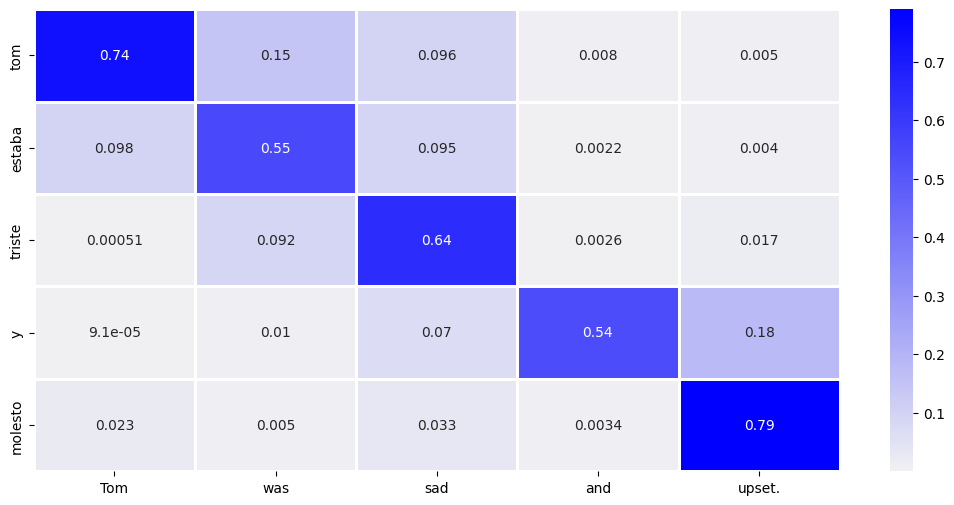

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(13, 6))

ax = sns.heatmap(
    alignment_matrix[:len(decoded_tokens), :len(input_tokens)],
    annot=True,
    cmap=sns.light_palette("blue", as_cmap=True),
    linewidths=1)

ax.set_xticklabels(input_tokens)
ax.set_yticklabels(decoded_tokens)

# Трансформер

**Класс `TransformerDecoder`**

In [79]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        else:
            padding_mask = mask
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)

**Слой PositionalEmbedding**

In [80]:
import keras.ops as ops

In [81]:
@keras.utils.register_keras_serializable()
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = ops.shape(inputs)[-1]
        positions = ops.arange(0, length, 1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return ops.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "sequence_length": self.sequence_length,
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

**End-to-end Трансформер**

In [ ]:
@keras.utils.register_keras_serializable()
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

In [ ]:
embed_dim = 256
dense_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="english")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="spanish")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'transformer_encoder_1' (of type TransformerEncoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


**Обучение**

In [ ]:
transformer.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

In [ ]:
# transformer = load_model('transformer.keras')
transformer.fit(train_ds, epochs=15, validation_data=val_ds)
transformer.summary()

Epoch 1/15
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 110s 37ms/step - accuracy: 0.1508 - loss: 4.5970 - val_accuracy: 0.1895 - val_loss: 3.0961
Epoch 2/15
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 88s 34ms/step - accuracy: 0.1967 - loss: 3.0932 - val_accuracy: 0.2288 - val_loss: 2.4258
Epoch 3/15
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 92s 35ms/step - accuracy: 0.2322 - loss: 2.4366 - val_accuracy: 0.2505 - val_loss: 2.0959
Epoch 4/15
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 91s 35ms/step - accuracy: 0.2555 - loss: 2.0338 - val_accuracy: 0.2621 - val_loss: 1.9257
Epoch 5/15
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 91s 35ms/step - accuracy: 0.2703 - loss: 1.7739 - val_accuracy: 0.2697 - val_loss: 1.8071
Epoch 6/15
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 89s 34ms/step - accuracy: 0.2808 - loss: 1.5845 - val_accuracy: 0.2738 - val_loss: 1.7628
Epoch 7/15
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 89s 34ms/step - accuracy: 0.2889 - loss: 1.4388 - val_accuracy: 0.2763 - val_loss: 1.7087
Epoch 8/15
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 88s 34ms/step - accuracy: 0.2954 

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ english             │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spanish             │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, None, 256) │  3,845,120 │ english[0][0]     │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_26        │ (None, None)      │          0 │ english[0][0]     │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, None, 256) │  3,845,120 │ spanish[0][0]     │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 256) │  3,155,456 │ positional_embed… │
│ (TransformerEncode… │                   │            │ not_equal_26[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decode… │ (None, None, 256) │  5,259,520 │ positional_embed… │
│ (TransformerDecode… │                   │            │ transformer_enco… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, None, 256) │          0 │ transformer_deco… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, None,      │  3,855,000 │ dropout_8[0][0]   │
│                     │ 15000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 59,880,650 (228.43 MB)

 Trainable params: 19,960,216 (76.14 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 39,920,434 (152.28 MB)

In [ ]:
transformer.save('transformer.keras')

**Пример перевода**

In [ ]:
import numpy as np
spa_vocab = target_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20

def decode_transformer_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization(
            [decoded_sentence])[:, :-1]
        predictions = transformer(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(20):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)
    print(decode_transformer_sequence(input_sentence))

-
This sounds like a trap.
[start] este suena como una trampa [end]
-
You can't deny that what Tom is saying is true.
[start] no puedes traducir de que tom esté diciendo es verdad [end]
-
Did Tom give you something?
[start] te hizo algo a tom [end]
-
Tom didn't tell anyone else.
[start] tom no dijo nada más [end]
-
He was impatient to see his son.
[start] Él estaba impaciente por ver a su hijo [end]
-
He stopped smoking and started running.
[start] Él dejó de fumar y empezó [end]
-
You don't even know my name.
[start] ni siquiera sabes mi nombre [end]
-
I can do magic.
[start] puedo hacer [UNK] [end]
-
This is all that I know about him.
[start] esto es todo lo que le conozco [end]
-
Love lasts.
[start] el amor [UNK] [end]
-
They're speaking French.
[start] están hablando francés [end]
-
Even his teacher didn't understand him.
[start] hasta el profesor de nombre no lo ha escrito [end]
-
You should not despise a man because he is poor.
[start] no deberías [UNK] a un hombre porque es pobr

# Оценка моделей

In [51]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

In [52]:
def make_train_dataset():
  short_pairs = list(filter(lambda x: len(x[0].split()) <= 5, test_pairs))
  short_pairs = [(pair[0], pair[1].replace("[start]", "").replace("[end]", "").strip()) for pair in short_pairs]
  short_pairs = np.array(short_pairs)

  medium_pairs = list(filter(lambda x: len(x[0].split()) > 5 and len(x[0].split()) <= 15, test_pairs))
  medium_pairs = [(pair[0], pair[1].replace("[start]", "").replace("[end]", "").strip()) for pair in medium_pairs]
  medium_pairs = np.array(medium_pairs)

  long_pairs = list(filter(lambda x: len(x[0].split()) > 15, test_pairs))
  long_pairs = [(pair[0], pair[1].replace("[start]", "").replace("[end]", "").strip()) for pair in long_pairs]
  long_pairs = np.array(long_pairs)

  short_pairs_idx = np.random.choice(short_pairs.shape[0], 10, replace=False)
  medium_pairs_idx = np.random.choice(medium_pairs.shape[0], 10, replace=False)
  long_pairs_idx = np.random.choice(long_pairs.shape[0], 10, replace=False)

  return short_pairs[short_pairs_idx], medium_pairs[medium_pairs_idx], long_pairs[long_pairs_idx]

In [53]:
short_pairs, medium_pairs, long_pairs = make_train_dataset()
short_pairs

array([['It was snowing.', 'Nevaba.'],
       ['That is not my pen.', 'Ese no es mi bolígrafo.'],
       ['They enjoyed themselves.', 'Ellos se divertían.'],
       ['Tom gave up hope.', 'Tom abandonó la esperanza.'],
       ['I like walking by myself.', 'Me gusta caminar solo.'],
       ['He reached his goal.', 'Él alcanzó su meta.'],
       ['Tom is a psychopath.', 'Tom es un psicópata.'],
       ['Tom misses you.', 'Tom te echa de menos.'],
       ['Tom glanced at his watch.', 'Tom ojeó su reloj.'],
       ["I think he's happy.", 'Yo creo que él es feliz.']], dtype='<U65')

In [ ]:
bleu_scores_rnn = {
    'short': [],
    'medium': [],
    'long': []
}
bleu_scores_rnn_attention = {
    'short': [],
    'medium': [],
    'long': []
}
bleu_scores_transformer = {
    'short': [],
    'medium': [],
    'long': []
}

In [ ]:
def compute_bleu(reference, hypothesis):
  reference_tokens = [reference.split()]
  hypothesis_tokens = hypothesis.split()

  bleu_score = sentence_bleu(
      reference_tokens,
      hypothesis_tokens,
      weights=[1],
      smoothing_function=SmoothingFunction().method1
  )

  return bleu_score

In [ ]:
for (input_sentence, target_sentence) in short_pairs:
  predicted_sentence_rnn = decode_rnn_sequence(input_sentence)
  predicted_sentence_rnn_attention = decode_rnn_attention_sequence(input_sentence)
  predicted_sentence_transformer = decode_transformer_sequence(input_sentence)

  predicted_sentence_rnn.replace("[start]", "").replace("[end]", "").strip()
  predicted_sentence_rnn_attention.replace("[start]", "").replace("[end]", "").strip()
  predicted_sentence_transformer.replace("[start]", "").replace("[end]", "").strip()

  bleu_scores_rnn['short'].append(compute_bleu(target_sentence, predicted_sentence_rnn))
  bleu_scores_rnn_attention['short'].append(compute_bleu(target_sentence, predicted_sentence_rnn_attention))
  bleu_scores_transformer['short'].append(compute_bleu(target_sentence, predicted_sentence_transformer))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━

In [ ]:
for (input_sentence, target_sentence) in medium_pairs:
  predicted_sentence_rnn = decode_rnn_sequence(input_sentence)
  predicted_sentence_rnn_attention = decode_rnn_attention_sequence(input_sentence)
  predicted_sentence_transformer = decode_transformer_sequence(input_sentence)

  predicted_sentence_rnn.replace("[start]", "").replace("[end]", "").strip()
  predicted_sentence_rnn_attention.replace("[start]", "").replace("[end]", "").strip()
  predicted_sentence_transformer.replace("[start]", "").replace("[end]", "").strip()

  bleu_scores_rnn['medium'].append(compute_bleu(target_sentence, predicted_sentence_rnn))
  bleu_scores_rnn_attention['medium'].append(compute_bleu(target_sentence, predicted_sentence_rnn_attention))
  bleu_scores_transformer['medium'].append(compute_bleu(target_sentence, predicted_sentence_transformer))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━

In [ ]:
for (input_sentence, target_sentence) in long_pairs:
  predicted_sentence_rnn = decode_rnn_sequence(input_sentence)
  predicted_sentence_rnn_attention = decode_rnn_attention_sequence(input_sentence)
  predicted_sentence_transformer = decode_transformer_sequence(input_sentence)

  predicted_sentence_rnn.replace("[start]", "").replace("[end]", "").strip()
  predicted_sentence_rnn_attention.replace("[start]", "").replace("[end]", "").strip()
  predicted_sentence_transformer.replace("[start]", "").replace("[end]", "").strip()

  bleu_scores_rnn['long'].append(compute_bleu(target_sentence, predicted_sentence_rnn))
  bleu_scores_rnn_attention['long'].append(compute_bleu(target_sentence, predicted_sentence_rnn_attention))
  bleu_scores_transformer['long'].append(compute_bleu(target_sentence, predicted_sentence_transformer))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━

In [ ]:
bleu_scores_rnn['short'] = np.mean(bleu_scores_rnn['short'])
bleu_scores_rnn['medium'] = np.mean(bleu_scores_rnn['medium'])
bleu_scores_rnn['long'] = np.mean(bleu_scores_rnn['long'])

bleu_scores_rnn_attention['short'] = np.mean(bleu_scores_rnn_attention['short'])
bleu_scores_rnn_attention['medium'] = np.mean(bleu_scores_rnn_attention['medium'])
bleu_scores_rnn_attention['long'] = np.mean(bleu_scores_rnn_attention['long'])

bleu_scores_transformer['short'] = np.mean(bleu_scores_transformer['short'])
bleu_scores_transformer['medium'] = np.mean(bleu_scores_transformer['medium'])
bleu_scores_transformer['long'] = np.mean(bleu_scores_transformer['long'])

In [ ]:
bleu_scores_rnn, bleu_scores_rnn_attention, bleu_scores_transformer

({'short': np.float64(0.1338888888888889),
  'medium': np.float64(0.24642857142857139),
  'long': np.float64(0.2070456362221249)},
 {'short': np.float64(0.1470238095238095),
  'medium': np.float64(0.297684250466475),
  'long': np.float64(0.20846776629781744)},
 {'short': np.float64(0.1573015873015873),
  'medium': np.float64(0.30879276352200896),
  'long': np.float64(0.28913349740764877)})

In [ ]:
short_data = [bleu_scores_rnn['short'], bleu_scores_rnn_attention['short'], bleu_scores_transformer['short']]
medium_data = [bleu_scores_rnn['medium'], bleu_scores_rnn_attention['medium'], bleu_scores_transformer['medium']]
long_data = [bleu_scores_rnn['long'], bleu_scores_rnn_attention['long'], bleu_scores_transformer['long']]

In [ ]:
import pandas as pd

pd.DataFrame({
    'Short texts': short_data,
    'Medium texts': medium_data,
    'Long texts': long_data
}, index=['RNN', 'RNN + attention', 'Transformer'])

,Short texts,Medium texts,Long texts
RNN,0.133889,0.246429,0.207046
RNN+attention,0.147024,0.297684,0.208468
Transformer,0.157302,0.308793,0.289133
